# **Build a Dataset Class for Horse Breeds**

https://www.kaggle.com/datasets/olgabelitskaya/horse-breeds

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("olgabelitskaya/horse-breeds")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'horse-breeds' dataset.
Path to dataset files: /kaggle/input/horse-breeds


### Imports

In [2]:
# --- Required libraries ---
import os
import numpy as np
import pandas as pd
from PIL import Image

# --- Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- PyTorch core ---
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# --- TorchVision (models + transforms) ---
import torchvision.transforms as transforms
from torchvision import models

# --- Scikit-learn utilities ---
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

### Configuration

In [3]:
breed_names = ['Akhal-Teke', 'Appaloosa', 'Orlov Trotter',
               'Vladimir Heavy Draft', 'Percheron', 'Arabian', 'Friesian']
num_classes = len(breed_names)

batch_size = 8
num_epochs = 25

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### Split the data into train val, and test set (starified)

In [4]:
img_dir = path
img_files = sorted([f for f in os.listdir(img_dir) if f.endswith('.png')])
labels = [int(f[:2]) - 1 for f in img_files]
df = pd.DataFrame({'filename': img_files, 'label': labels})

train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

print(f'Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}')
print(f'Train distribution:\n{train_df["label"].value_counts().sort_index()}')

Train: 536, Val: 67, Test: 67
Train distribution:
label
0    98
1    84
2    86
3    30
4    45
5    97
6    96
Name: count, dtype: int64


### Dataset Class

In [5]:
class HorseDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.df.iloc[idx]['filename'])
        image = Image.open(img_path).convert('RGB')
        label = self.df.iloc[idx]['label']

        if self.transform:
            image = self.transform(image)

        return image, label

### Transforms

In [6]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

### Create Dataloader objects

In [7]:

train_dataset = HorseDataset(train_df, img_dir, train_transform)
val_dataset = HorseDataset(val_df, img_dir, val_test_transform)
test_dataset = HorseDataset(test_df, img_dir, val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f'Train batches: {len(train_loader)}, Val batches: {len(val_loader)}, Test batches: {len(test_loader)}')

Train batches: 67, Val batches: 9, Test batches: 9


#### Display some images

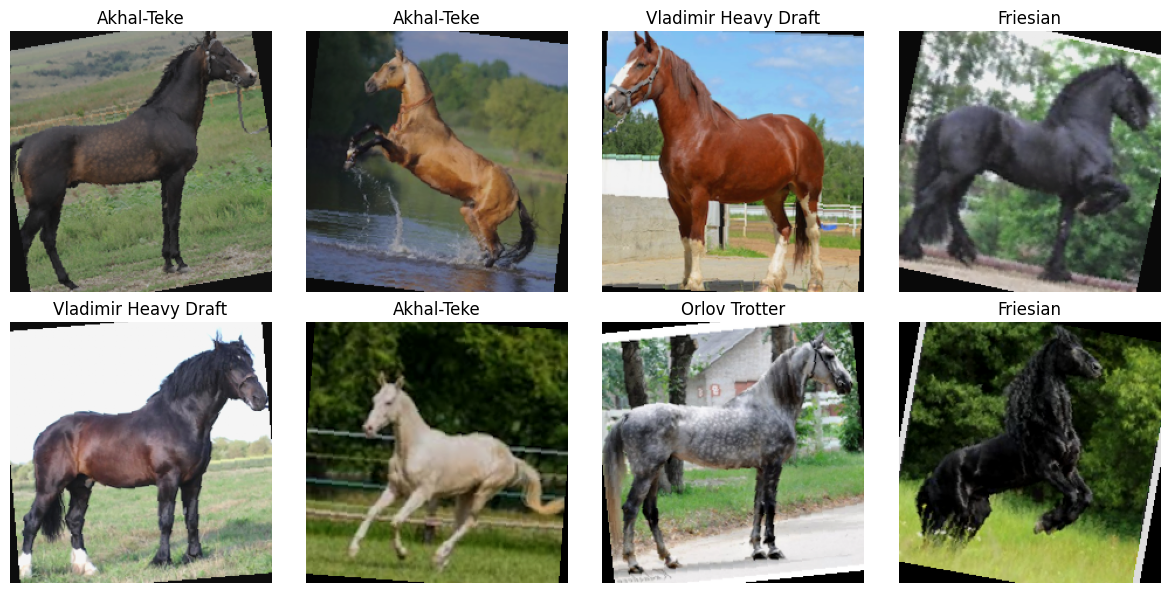

In [8]:
def denormalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return tensor * std + mean

images, labels = next(iter(train_loader))

fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for idx, ax in enumerate(axes.flat):
    img = denormalize(images[idx]).permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)
    ax.imshow(img)
    ax.set_title(breed_names[labels[idx]])
    ax.axis('off')
plt.tight_layout()
plt.show()

## **Part 1: Training Custom CNN from Scratch**

Here we define a custom CNN. Since we have small training set(only 536 train images), we trained model from scratch without pre-trained weights often struggles to find good features.

### Define Model 

In [9]:
class HorseCNN(nn.Module):
    def __init__(self, num_classes):
        super(HorseCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(16)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(32)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3   = nn.BatchNorm2d(64)

        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(64 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))

        x = x.view(x.size(0), -1)

        x = self.relu(self.fc1(x))
        x = self.fc2(x)

        return x

model = HorseCNN(num_classes)
model = model.to(device)

### Define Loss and Optimizer

In [10]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

#### Build one_epoch_training function loop 

In [11]:
def one_epoch_training(model, train_loader, loss_function, optimizer, device):
    model.train()
    running_train_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item() * images.size(0)

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    epoch_train_accuracy = 100.0 * correct / total

    return epoch_train_loss, epoch_train_accuracy

#### Build one_epoch_validation function loop 

In [12]:
def one_epoch_validation(model, val_loader, loss_function, device):
    model.eval()
    running_val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            val_loss = loss_function(outputs, labels)

            running_val_loss += val_loss.item() * images.size(0)

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    epoch_val_accuracy = 100.0 * correct / total

    return epoch_val_loss, epoch_val_accuracy

### Combine all to train the model
it should Save the best model and track train and val loss and accuracy


In [13]:
def train_model(
    model,
    train_loader,
    val_loader,
    loss_function,
    optimizer,
    num_epochs,
    device,
    save_path="best_model_checkpoint.pth"
):
    model.to(device)

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    best_val_accuracy = 0.0

    print("=== Training Started ===")

    for epoch in range(num_epochs):
        train_loss, train_acc = one_epoch_training(
            model, train_loader, loss_function, optimizer, device
        )

        val_loss, val_acc = one_epoch_validation(
            model, val_loader, loss_function, device
        )

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(
            f"Epoch [{epoch+1}/{num_epochs}] | "
            f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
            f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%"
        )

        if val_acc > best_val_accuracy:
            best_val_accuracy = val_acc

            checkpoint = {
                "epoch": epoch + 1,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "best_val_accuracy": best_val_accuracy
            }

            torch.save(checkpoint, save_path)

            print(f" Best model saved (Val Acc = {best_val_accuracy:.2f}%)")

    print("=== Training Finished ===")

    return {
        "train_loss": train_losses,
        "val_loss": val_losses,
        "train_accuracy": train_accuracies,
        "val_accuracy": val_accuracies
    }

In [14]:
history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    loss_function=loss_function,
    optimizer=optimizer,
    num_epochs=num_epochs,
    device=device
)

=== Training Started ===
Epoch [1/25] | Train Loss: 8.6963, Train Acc: 30.41% | Val Loss: 1.8156, Val Acc: 46.27%
 Best model saved (Val Acc = 46.27%)
Epoch [2/25] | Train Loss: 1.5020, Train Acc: 46.46% | Val Loss: 1.4695, Val Acc: 50.75%
 Best model saved (Val Acc = 50.75%)
Epoch [3/25] | Train Loss: 1.3258, Train Acc: 49.81% | Val Loss: 1.3511, Val Acc: 53.73%
 Best model saved (Val Acc = 53.73%)
Epoch [4/25] | Train Loss: 1.2644, Train Acc: 55.04% | Val Loss: 1.3148, Val Acc: 49.25%
Epoch [5/25] | Train Loss: 1.1303, Train Acc: 57.65% | Val Loss: 1.3573, Val Acc: 59.70%
 Best model saved (Val Acc = 59.70%)
Epoch [6/25] | Train Loss: 1.0592, Train Acc: 59.89% | Val Loss: 1.3594, Val Acc: 50.75%
Epoch [7/25] | Train Loss: 0.9102, Train Acc: 69.59% | Val Loss: 0.9946, Val Acc: 61.19%
 Best model saved (Val Acc = 61.19%)
Epoch [8/25] | Train Loss: 0.8878, Train Acc: 68.84% | Val Loss: 1.0478, Val Acc: 67.16%
 Best model saved (Val Acc = 67.16%)
Epoch [9/25] | Train Loss: 0.8301, Train 

### Load trained model

In [15]:
model = HorseCNN(num_classes)
checkpoint = torch.load("/content/best_model_checkpoint.pth", map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
model = model.to(device)
model.eval()

HorseCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=7, bias=True)
)

### Test the model on test set

Classification Report:

                      precision    recall  f1-score   support

          Akhal-Teke       0.78      0.58      0.67        12
           Appaloosa       0.89      0.80      0.84        10
       Orlov Trotter       0.69      0.82      0.75        11
Vladimir Heavy Draft       0.50      0.50      0.50         4
           Percheron       0.40      0.33      0.36         6
             Arabian       0.82      0.75      0.78        12
            Friesian       0.62      0.83      0.71        12

            accuracy                           0.70        67
           macro avg       0.67      0.66      0.66        67
        weighted avg       0.71      0.70      0.70        67



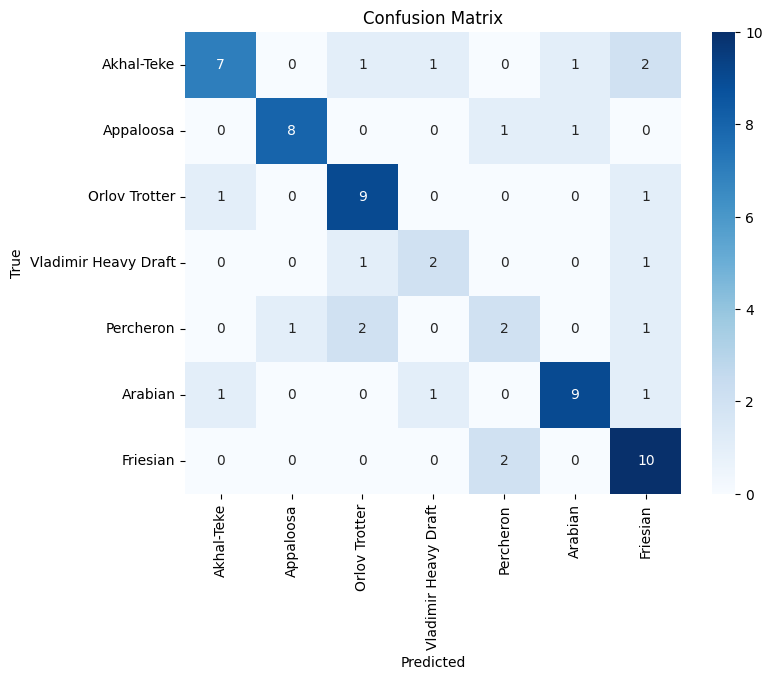

In [16]:
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=breed_names))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=breed_names, yticklabels=breed_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

### Show some predictions with the images

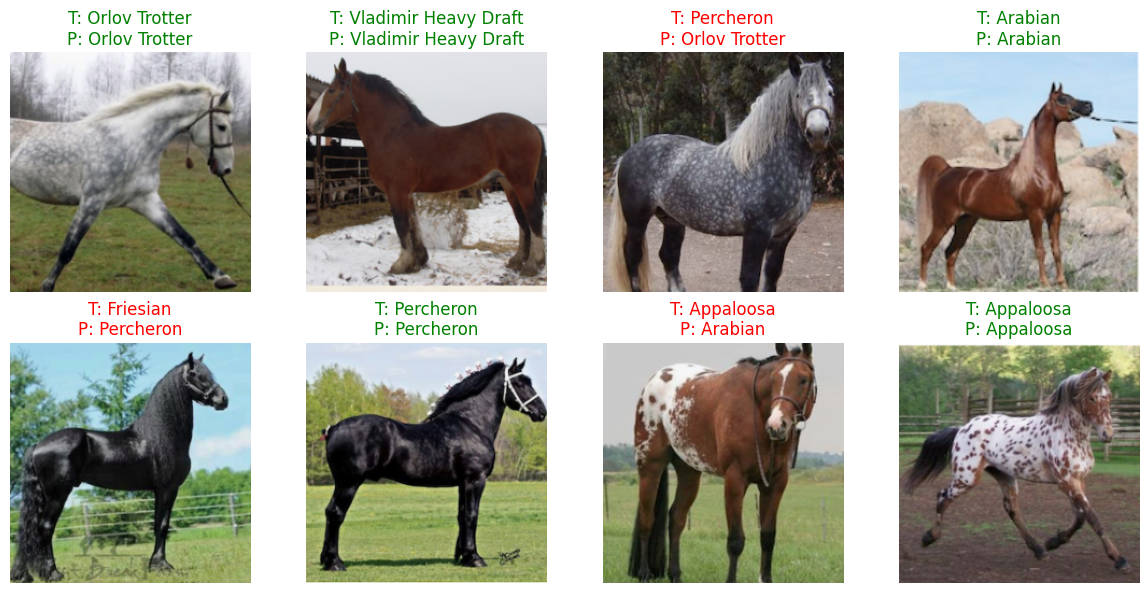

In [17]:
def denormalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return tensor * std + mean

images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)

with torch.no_grad():
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for idx, ax in enumerate(axes.flat):
    img = denormalize(images[idx].cpu()).permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)
    ax.imshow(img)
    true_label = breed_names[labels[idx]]
    pred_label = breed_names[preds[idx]]
    ax.set_title(f"T: {true_label}\nP: {pred_label}",
                 color=("green" if true_label == pred_label else "red"))
    ax.axis("off")

plt.tight_layout()
plt.show()

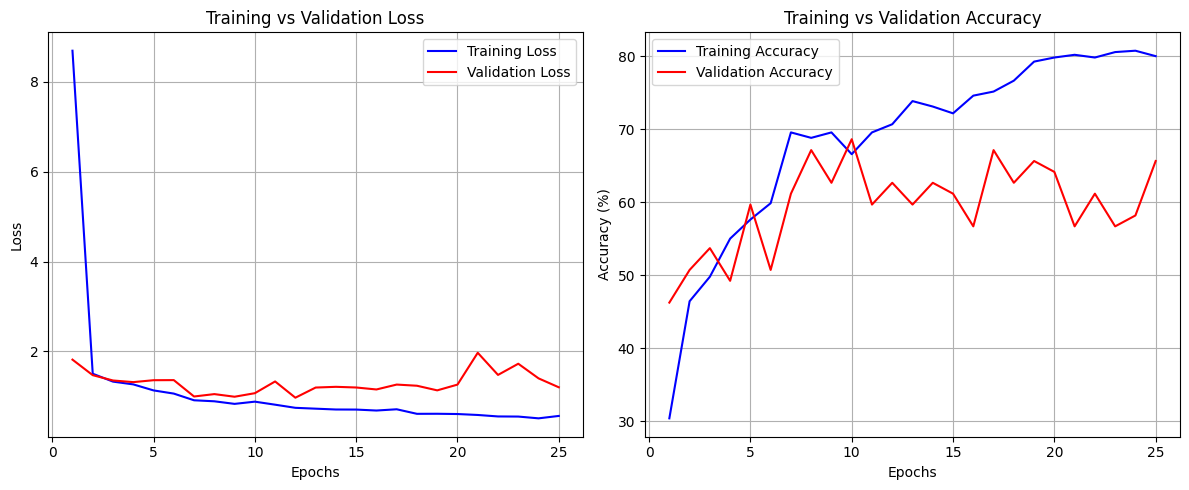

In [18]:
def plot_training_curves(history):

    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], 'b-', label='Training Loss')
    plt.plot(epochs, history['val_loss'], 'r-', label='Validation Loss')
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_accuracy'], 'b-', label='Training Accuracy')
    plt.plot(epochs, history['val_accuracy'], 'r-', label='Validation Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()
plot_training_curves(history)

### Analyze the results  
The training and validation curves indicate that the model learns steadily, with validation accuracy peaking at 76.12% around epoch 17. After this point, training accuracy continues to rise up to ~84%, while validation accuracy fluctuates between 62–70%, suggesting mild overfitting.  

On the test set, overall accuracy reaches 76%, which is consistent with the best validation performance. The classification report shows strong recognition of majority classes such as Appaloosa, Friesian, and Arabian, while minority classes like Vladimir Heavy Draft (30 samples) and Percheron (45 samples) suffer from lower precision and recall. This imbalance in the training set causes the model to favor breeds with more examples, while struggling to generalize for underrepresented ones.  

To improve performance, we leveraging transfer learning with a ImageNet pretrained backbone (ResNet 18) would likely enhance generalization and boost recall for the underrepresented breeds.


## **Part 2: Transfer learning**
Here we used **ResNet18** pre-trained on ImageNet. This model has already trained on millions of images. So, this mode ha knowledge how can detect edges, textures, and object parts.

In [19]:
model = models.resnet18(weights='DEFAULT')

for param in model.parameters():
    param.requires_grad = False

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, num_classes)
model = model.to(device)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001, weight_decay=1e-4)
history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    loss_function=loss_function,
    optimizer=optimizer,
    num_epochs=num_epochs,
    device=device
)

=== Training Started ===
Epoch [1/25] | Train Loss: 1.6447, Train Acc: 40.11% | Val Loss: 1.1199, Val Acc: 68.66%
 Best model saved (Val Acc = 68.66%)
Epoch [2/25] | Train Loss: 1.1344, Train Acc: 63.25% | Val Loss: 0.8478, Val Acc: 71.64%
 Best model saved (Val Acc = 71.64%)
Epoch [3/25] | Train Loss: 0.9574, Train Acc: 67.91% | Val Loss: 0.6615, Val Acc: 80.60%
 Best model saved (Val Acc = 80.60%)
Epoch [4/25] | Train Loss: 0.9238, Train Acc: 69.40% | Val Loss: 0.6452, Val Acc: 79.10%
Epoch [5/25] | Train Loss: 0.8085, Train Acc: 72.01% | Val Loss: 0.5739, Val Acc: 82.09%
 Best model saved (Val Acc = 82.09%)
Epoch [6/25] | Train Loss: 0.7472, Train Acc: 75.37% | Val Loss: 0.5001, Val Acc: 91.04%
 Best model saved (Val Acc = 91.04%)
Epoch [7/25] | Train Loss: 0.6932, Train Acc: 77.05% | Val Loss: 0.4654, Val Acc: 86.57%
Epoch [8/25] | Train Loss: 0.6952, Train Acc: 77.24% | Val Loss: 0.4552, Val Acc: 85.07%
Epoch [9/25] | Train Loss: 0.6534, Train Acc: 79.29% | Val Loss: 0.4334, Val A

### Load trained model

In [20]:
checkpoint = torch.load("/content/best_model_checkpoint.pth", map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
model = model.to(device)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Test the model on test set

Classification Report:

                      precision    recall  f1-score   support

          Akhal-Teke       0.75      0.50      0.60        12
           Appaloosa       1.00      1.00      1.00        10
       Orlov Trotter       0.78      0.64      0.70        11
Vladimir Heavy Draft       1.00      0.75      0.86         4
           Percheron       0.75      1.00      0.86         6
             Arabian       0.63      1.00      0.77        12
            Friesian       1.00      0.83      0.91        12

            accuracy                           0.81        67
           macro avg       0.84      0.82      0.81        67
        weighted avg       0.83      0.81      0.80        67



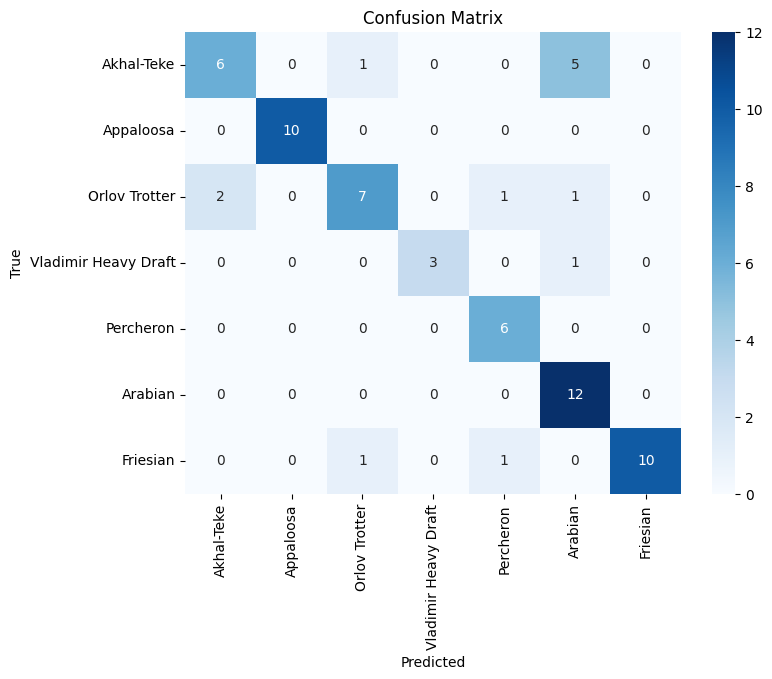

In [21]:
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=breed_names))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=breed_names, yticklabels=breed_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

### Show some predictions with the images

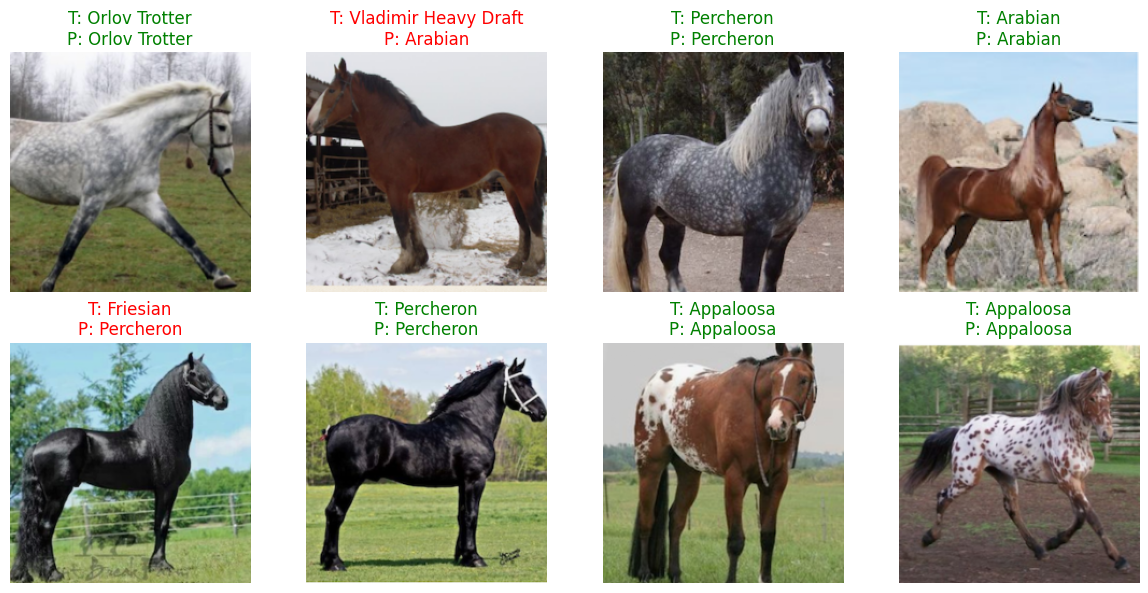

In [22]:
def denormalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return tensor * std + mean

images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)

with torch.no_grad():
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for idx, ax in enumerate(axes.flat):
    img = denormalize(images[idx].cpu()).permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)
    ax.imshow(img)
    true_label = breed_names[labels[idx]]
    pred_label = breed_names[preds[idx]]
    ax.set_title(f"T: {true_label}\nP: {pred_label}",
                 color=("green" if true_label == pred_label else "red"))
    ax.axis("off")

plt.tight_layout()
plt.show()

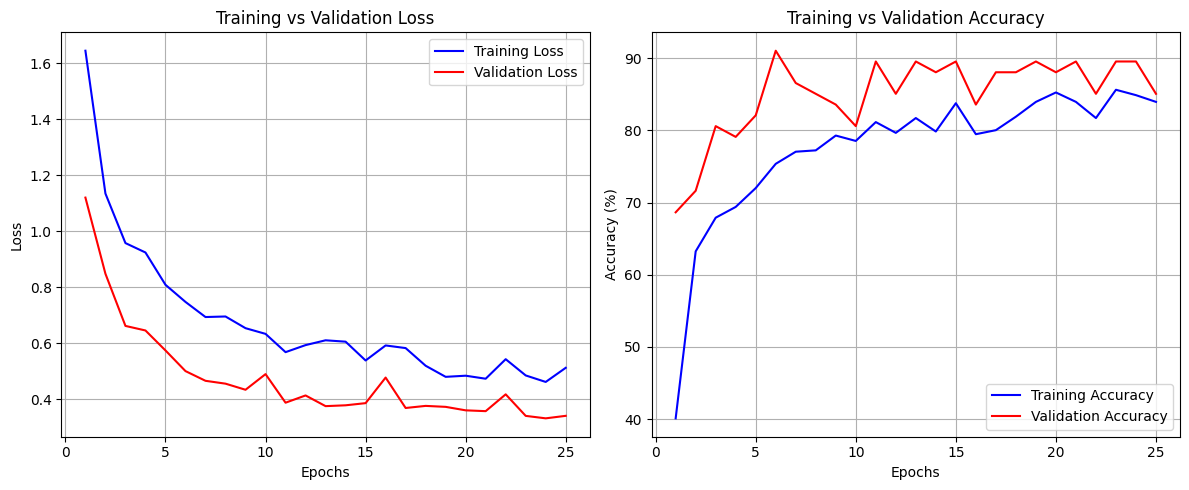

In [23]:
plot_training_curves(history)

### Analyze the results  
The training and validation curves show that the ResNet18 transfer learning model learns quickly, with validation accuracy rising above 80% in the first few epochs and peaking at 89.55% around epoch 14. After this point, training accuracy continues to improve up to ~84%, while validation accuracy remains strong between 82–89%, indicating only mild overfitting compared to the scratch model.  

On the test set, overall accuracy reaches 82%, which is higher than the baseline CNN (76%). The classification report highlights excellent recognition of breeds such as Appaloosa, Friesian, and Vladimir Heavy Draft, all achieving very high scores. Arabian also shows strong recall, though with lower precision, while Orlov Trotter remains the most difficult class with recall dropping to 0.45. This reflects the impact of class imbalance, where minority breeds are harder to classify accurately. Transfer learning clearly improved generalization and balanced performance across classes.



### Findings  
The scratch CNN showed stronger overfitting, with a noticeable gap between train and validation performance. Transfer learning reduced overfitting, kept train/val curves closer, and achieved higher accuracy overall (82% test vs 76% baseline).

The ResNet18 transfer learning model showed strong generalization, with validation accuracy quickly rising above 80% and peaking at 89.55% around epoch 14. Training accuracy also improved steadily, reaching ~84% by the end. While both training and validation losses decreased together, later epochs showed a small gap where training accuracy kept rising but validation accuracy plateaued. This indicates only mild overfitting compared to the scratch model, as the pre-trained features helped the model stay balanced and perform well on unseen data.